In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

device = torch.device("cuda")

In [ ]:
"""
This section grabs the SemEval dataset from Dropbox.
Requires a dropbox API key.
"""
import os.path

if not os.path.isfile('semeval.zip'):
  try:
    import dropbox
  except:
    !pip3 install dropbox
    import dropbox

  ACCESS_TOKEN = input("Enter in your access token")
  dbx = dropbox.Dropbox(ACCESS_TOKEN)
  with open("semeval.zip", "wb") as f:
      metadata, res = dbx.files_download(path="/2017_English_final.zip")
      f.write(res.content)

In [ ]:
"""
This section processes the data files and loads the data into a dataframe
"""
# unzip data if folder is not present
if not os.path.isdir('semeval'):
  import zipfile
  with zipfile.ZipFile('semeval.zip', 'r') as zip_ref:
      zip_ref.extractall('semeval')

# get all folders with relavent data in them
task_folders = [f'semeval/2017_English_final/GOLD/{folder}'
                for folder in os.listdir('semeval/2017_English_final/GOLD') 
                if os.path.isdir(f'semeval/2017_English_final/GOLD/{folder}')
]

mapping = {'-2': 'negative', '-1': 'negative', '0': 'neutral', '1': 'positive', '2': 'positive'}

# create a generator for SemEval Twitter Data
# the data files are separated by tab and each folder has it's own data format
def parseTwitter(folders):
  for folder in folders:
    for file in [f'{folder}/{f}' for f in os.listdir(folder) if 'twitter' in f]:
      with open(file, 'r') as f:
        for line in f:
          segments = line.rstrip().split('\t')
          if len(segments) < 3:
            continue
          elif 'A' in folder:
            tweet_data = [segments[0], segments[1], ''.join(segments[2:])]
          elif 'B' in folder:
            tweet_data = [segments[0], segments[-2], segments[-1]]
          else:
            tweet_data = [segments[0], mapping[segments[-2]], segments[-1]]
          yield tweet_data

# create a pandas dataframe
df = pd.DataFrame(parseTwitter(task_folders), columns=['TweetId', 'Sentiment', 'Text'])


In [ ]:
df.groupby(['Sentiment']).agg('count')

,TweetId,Text
Sentiment,,
negative,15550,15550
neutral,37128,37128
positive,48796,48796


In [ ]:
df.head()

,TweetId,Sentiment,Text
0,637641175948763136,positive,@SeeMonterey LOST - Sony cell phone with holid...
1,637651487762554881,neutral,"@PersonaSoda well yeah, that's third parties. ..."
2,637666734300905472,negative,Sony rewards app is like a lot of 19 y.o femal...
3,637668142110654468,positive,@fakethom Have android tab and don't use phone...
4,637708370129125377,positive,Finally I get my ps4 back I sent it to Sony ca...


In [ ]:
"""
Clean up data and
Split the input into training set and test set
The data is split as follows
70 % training set, 15% test set, 15% validation set
"""
# eliminate off topic tweets and make categorical
df = df[df.Sentiment != 'off topic']
df.Sentiment = pd.Categorical(df.Sentiment)

train_text, temp_text, train_labels, temp_labels = train_test_split(df['Text'], df['Sentiment'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Sentiment'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
"""
Install CT-Bert from huggingface along with other modules
"""
!pip3 install transformers
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)


     |████████████████████████████████| 1.3MB 7.8MB/s 
     |████████████████████████████████| 890kB 17.0MB/s 
     |████████████████████████████████| 1.1MB 40.6MB/s 
     |████████████████████████████████| 2.9MB 42.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1e5d7a30cb1249c8adad9422d0fe907d86a87ca2729ee07bc169354387f79101
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
"""
Choose the tokenizer from CT-BERT
"""
model_name = 'digitalepidemiologylab/covid-twitter-bert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

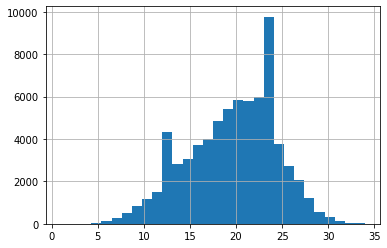

In [ ]:
"""
Display information of the how long each tweet is
"""
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
"""
Use CT-BERT to Tokenize the tweet text for training, test and validation sets
"""
max_seq_len = 35

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
